# WNS Analytics Wizard

Importing libraries

In [1]:
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

Creating useful functions

In [2]:
def evaluate(actual, predicted, predicted_probability):
    print("Confusion Matrix")
    print(pd.DataFrame(confusion_matrix(actual, predicted)))
    print("")
    print("For Class 1")
    print("f1 Score :", f1_score(actual, predicted))
    print("Precision Score :",precision_score(actual, predicted))
    print("Recall Score :",recall_score(actual, predicted))
    print("")
    print("For Class 0")
    print("f1 Score :", f1_score(1-np.array(actual), 1-np.array(predicted)))
    print("Precision Score :",precision_score(1-np.array(actual), 1-np.array(predicted)))
    print("Recall Score :",recall_score(1-np.array(actual), 1-np.array(predicted)))
    print("")
    print("AUROC :",  roc_auc_score(actual, predicted_probability[:,1]))

In [3]:
def plot_roc(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    _ = plt.title('ROC')
    _ = plt.plot(fpr, tpr, 'b', alpha=0.2)
#     _ = plt.plot([0, 1], [0, 1],'r--', alpha=0.2)
    _ = plt.xlim([0, 1])
    _ = plt.ylim([0, 1])
    _ = plt.ylabel('True Positive Rate')
    _ = plt.xlabel('False Positive Rate')
    plt.show()

In [4]:
def generate_submission(impression_ids, is_clicks, method_name):
    submission_frame = pd.DataFrame(is_clicks, index=impression_ids)
    submission_frame.columns = ['is_click']
    submission_frame.index.name = 'impression_id'
    print(submission_frame.head())
    submission_frame.to_csv('data/test/'+method_name+'.csv')

In [44]:
def flow(X, y, training_func, X_future, y_future_ids):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2019)
    
    model = training_func(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)
    evaluate(y_test, y_pred, y_pred_prob)
    plot_roc(y_test, y_pred)
    
    y_future_pred = model.predict(X_future)
    generate_submission(y_future_ids, y_future_pred, training_func.__name__)
    
    return X_test, y_test, y_pred
    

## Data Wrangling User details

In [6]:
# # Read Items
# user_details = pd.read_csv('data/train/user_details.csv', index_col='user_id')
# user_details.head()

## Feature Engineering

In [7]:
training_df = pd.read_csv('data/train/train.csv', index_col='impression_id', parse_dates=['impression_time'])
training_df.os_version = training_df.os_version.replace({'old':0,'intermediate':1,'latest':2})
training_df.head()

,impression_time,user_id,app_code,os_version,is_4G,is_click
impression_id,,,,,,
c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,0,0,0
45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,2,1,1
70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,1,1,0
8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,2,1,0
182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,2,0,0


In [16]:
time_series_user_data = training_df.set_index(['user_id','app_code','impression_time']).sort_index()
time_series_user_data = time_series_user_data[['is_click']]
time_series_user_data.head()

is_click
user_id app_code impression_time              
0       207      2018-11-26 23:30:00         0
2       190      2018-11-19 20:49:00         0
                 2018-11-20 20:29:00         0
                 2018-11-20 20:53:00         0
                 2018-11-21 21:47:00         0

In [32]:
time_series_user_data.loc[(87862, 422), :][:'2018-11-15 00:00:00'][:-1]

,is_click
impression_time,


In [55]:
def get_click_ratio(row):
    previous_record = time_series_user_data.loc[(row.user_id, row.app_code), :][:row.impression_time][:-1]
    total_ads = previous_record.shape[0]
    total_clicks = previous_record.is_click.sum()
    return (total_clicks / total_ads) if total_ads != 0 else 0.0

In [56]:
training_df['click_ratio'] = training_df.apply(get_click_ratio, axis=1)
training_df.head()

,impression_time,user_id,app_code,os_version,is_4G,is_click,click_ratio
impression_id,,,,,,,
c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,0,0,0,0.0
45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,2,1,1,0.0
70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,1,1,0,0.0
8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,2,1,0,0.0
182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,2,0,0,0.0


In [57]:
training_df.to_csv('data/train/train_with_ratio.csv')

In [ ]:
# feature_cols = ['max_price', 'min_price', 'total_items', 'total_unique_items', 'total_sessions', 
#                 'freq_product_type', 'freq_device', 'app_code', 'os_version_int', 'is_4G','user_id']
# categorical_feature = [5, 6, 7, 8, 9, 10]
# os_version_map = {'old':0,'intermediate':1,'latest':2}

In [ ]:
# def extract_features(dataframe):
#     sub_dataframe = dataframe[['user_id','app_code','os_version','is_4G']]
#     sub_dataframe['os_version_int'] = sub_dataframe['os_version'].replace(os_version_map)
#     merged_dataframe = pd.merge(sub_dataframe, user_details, how='left', on='user_id')
#     return merged_dataframe[feature_cols].values

In [70]:
# Reading Training Data
# training_df = pd.read_csv('data/train/train.csv', index_col='impression_id', parse_dates=['impression_time'])
X = training_df[['user_id','app_code','os_version','click_ratio']].values
y = training_df['is_click'].values
X[:1]

array([[87862.,   422.,     0.,     0.]])

In [85]:
def get_click_ratio_future(row):
    try:
        previous_record = time_series_user_data.loc[(row.user_id, row.app_code), :]
        total_ads = previous_record.shape[0]
        total_clicks = previous_record.is_click.sum()
        return (total_clicks / total_ads) if total_ads != 0 else 0.0
    except KeyError:
        return 0.0

In [86]:
testing_df = pd.read_csv('data/test/test.csv', index_col='impression_id', parse_dates=['impression_time'])
testing_df.os_version = testing_df.os_version.replace({'old':0,'intermediate':1,'latest':2})
testing_df['click_ratio'] = testing_df.apply(get_click_ratio_future, axis=1)
testing_df.head()

,impression_time,user_id,app_code,os_version,is_4G,click_ratio
impression_id,,,,,,
a9e7126a585a69a32bc7414e9d0c0ada,2018-12-13 07:44:00,44754,127,2,1,0.0
caac14a5bf2ba283db7708bb34855760,2018-12-13 07:45:00,29656,44,2,0,0.0
13f10ba306a19ce7bec2f3cae507b698,2018-12-13 07:46:00,25234,296,2,1,0.0
39c4b4dc0e9701b55a0a4f072008fb3f,2018-12-13 07:47:00,22988,207,2,1,0.0
bf5a572cca75f5fc67f4b14e58b11d70,2018-12-13 07:48:00,35431,242,2,1,0.2


In [87]:
X_future = testing_df[['user_id','app_code','os_version','click_ratio']].values
y_future_ids = testing_df.index.values
X_future.shape

(90675, 4)

In [88]:
testing_df.to_csv('data/test/test_with_ratio.csv')

In [ ]:
# # Reading Testing Data
# testing_df = pd.read_csv('data/test/test.csv', index_col='impression_id', parse_dates=['impression_time'])
# X_future = extract_features(testing_df)
# y_future_ids = testing_df.index.values
# X_future[:1]

## Trying LightGBM

best_estimator LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               eval_metric='auc', importance_type='split', learning_rate=0.1,
               max_depth=5, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=2019, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)
best_score 0.7236940831805343
Confusion Matrix
       0   1
0  56593  26
1   2765  19

For Class 1
f1 Score : 0.01343230823612584
Precision Score : 0.4222222222222222
Recall Score : 0.006824712643678161

For Class 0
f1 Score : 0.975934883640722
Precision Score : 0.95341824185451
Recall Score : 0.9995407901941045

AUROC : 0.7249649578458797


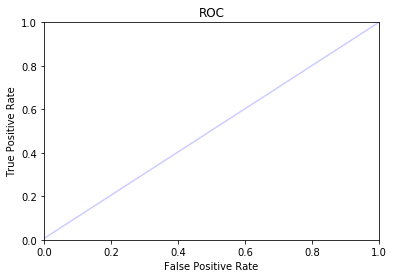

                                  is_click
impression_id                             
a9e7126a585a69a32bc7414e9d0c0ada         0
caac14a5bf2ba283db7708bb34855760         0
13f10ba306a19ce7bec2f3cae507b698         0
39c4b4dc0e9701b55a0a4f072008fb3f         0
bf5a572cca75f5fc67f4b14e58b11d70         0


In [89]:
def tunned_light_gbm_ratio(X_train, y_train):
    lgb = LGBMClassifier(eval_metric = 'auc',random_state=2019)
    params = {
        'max_depth': [1, 5, 10],
        'learning_rate': [0.01, 0.1, 0.5]
    }
    lgb_grid = GridSearchCV(lgb, params, cv=10, scoring='roc_auc')
    lgb_grid.fit(X_train, y_train, categorical_feature=[0,1,2])
    print('best_estimator', lgb_grid.best_estimator_)
    print('best_score', lgb_grid.best_score_)
    return lgb_grid.best_estimator_

X_test, y_test, y_pred = flow(X, y, tunned_light_gbm_ratio, X_future, y_future_ids)

In [91]:
validate_test_df = pd.DataFrame(X_test)
validate_test_df.columns = ['user_id','app_code','os_version','click_ratio']
validate_test_df['expected'] = y_test
validate_test_df['actual'] = y_pred
validate_test_df.head()

,user_id,app_code,os_version,click_ratio,expected,actual
0,75131.0,283.0,2.0,0.0,0,0
1,47401.0,285.0,0.0,0.0,0,0
2,66292.0,213.0,1.0,0.0,0,0
3,81649.0,129.0,2.0,0.0,0,0
4,77831.0,213.0,2.0,0.0,0,0


In [76]:
validate_test_df[validate_test_df.user_id == 65841]

,user_id,app_code,os_version,click_ratio,expected,actual
181,65841.0,244.0,2.0,0.187500,0,0
2433,65841.0,244.0,2.0,0.200000,0,0
2525,65841.0,244.0,2.0,0.000000,0,0
10343,65841.0,244.0,2.0,0.111111,0,0
15223,65841.0,244.0,2.0,0.176471,0,0
16623,65841.0,244.0,2.0,0.142857,0,0
32086,65841.0,244.0,2.0,0.000000,0,0
39564,65841.0,244.0,2.0,0.157895,0,0


In [92]:
false_positive = validate_test_df[(validate_test_df.expected == 0) & (validate_test_df.actual == 1)]
false_positive.head()

,user_id,app_code,os_version,click_ratio,expected,actual
6118,69062.0,37.0,0.0,0.600000,0,1
12046,52382.0,207.0,2.0,0.000000,0,1
12338,52211.0,244.0,0.0,0.166667,0,1
16983,54611.0,151.0,2.0,0.200000,0,1
18198,10315.0,217.0,1.0,0.750000,0,1


In [93]:
false_positive[false_positive.user_id==52382]

,user_id,app_code,os_version,click_ratio,expected,actual
12046,52382.0,207.0,2.0,0.0,0,1
40683,52382.0,207.0,2.0,0.0,0,1


In [95]:
training_df[(training_df.user_id==52382) & (training_df.click_ratio==0.0) & (training_df.app_code==207)]

,impression_time,user_id,app_code,os_version,is_4G,is_click,click_ratio
impression_id,,,,,,,
9f1f64b519d20e2ccc36e1589a8f7555,2018-11-15 11:09:00,52382,207,2,0,0,0.0
a41b3bb3e6b050b6c9067c67f663b915,2018-11-15 09:02:00,52382,207,2,0,0,0.0
c2eeaacb03e0bb62d5ffb626a9a3b79d,2018-11-23 16:04:00,52382,207,2,0,0,0.0
d6a65c9d345483ae4a545c748c66c9de,2018-11-27 08:59:00,52382,207,2,0,1,0.0


In [54]:
previous_record = time_series_user_data.loc[(52737, 32), :][:'2018-11-30 11:52:00'][:-1]
total_ads = previous_record.shape[0]
total_clicks = previous_record.is_click.sum()
(total_clicks / total_ads) if total_ads != 0 else 0.0

0.3333333333333333